In [86]:
%matplotlib notebook
import datetime
import obspy
import warnings
warnings.filterwarnings('ignore')

N=7.
minM = 4.9
lon=[-110,-70]
lat=[-10,30]
net='NU'
end = (datetime.datetime.now()).isoformat()
start = (datetime.datetime.now()-datetime.timedelta(days=N)).isoformat()

# Review of the earthquake early warning system for the N days. 

In [99]:
print('Into area %s°N %s°E' % (str(lat), str(lon)))
print("from %s" % start )
print("  to %s" % end )
print('for network %s.' % net)


Into area [-10, 30]°N [-110, -70]°E
from 2017-02-16T13:01:24.180338
  to 2017-02-23T13:01:24.180202
for network NU.


## Global observations

<IPython.core.display.Javascript object>


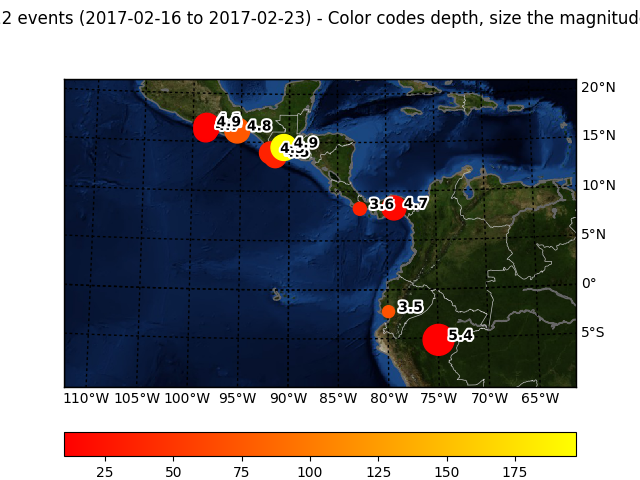

In [73]:
url="http://earthquake.usgs.gov/fdsnws/event/1/query.quakeml?starttime="+start+"&endtime="+end+"&minlat="+lat[0]+"&maxlat="+lat[1]+"&minlon="+lon[0]+"&maxlon="+lon[1]+"&orderby=magnitude-asc"
cat = obspy.read_events(str(url))
#url="https://service.iris.edu/fdsnws/station/1/query?starttime="+start+"&endtime="+end+"&minlat=-10&maxlat=30&minlon=-110&maxlon=-70&level=station&format=xml&nodata=404"
#inv = obspy.read_inventory(str(url))
fig = cat.plot(projection='local',resolution='i',continent_fill_color='None',water_fill_color='None',colormap='autumn')
fig.bmap.bluemarble()

## INETER observations
### Available network

<IPython.core.display.Javascript object>


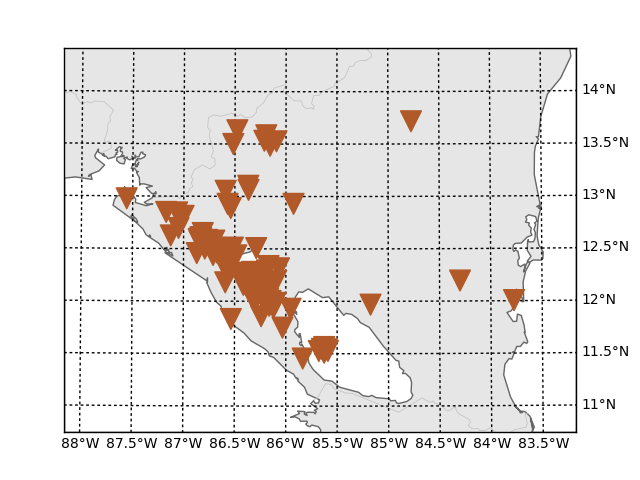

Inventory created at 2017-02-23T11:50:32.000000Z
	Sending institution: SeisComP3 (INETER)
	Contains:
		Networks (1):
			NU
		Stations (103):
			NU.AAHN (Alcaldia de Achuapa)
			NU.ABCN (SMA Banco Central, Nicaragua)
			NU.ACBN (SMA Campo Bello, Nicaragua)
			NU.ACON (Acoyapa, Nicaragua)
			NU.ACSN (SMA Ciudad Sandino, Nicaragua)
			NU.ADRN (SMA Diriamba, Nicaragua)
			NU.AERN (SMA Aeropuerto Managua, Nicaragua)
			NU.AESN (EL SAUCE LEON)
			NU.ALEN (SMA Leon, Nicaragua)
			NU.ALLN (SMA Telcor Managua, Nicaragua)
			NU.ALTN (Altagracia, Isla de ometepe)
			NU.AMTN (SMA Mateare, Nicaragua)
			NU.AMYN (SMA CODE Masaya, Nicaragua)
			NU.APQ2 (Apoyeque, Nicaragua)
			NU.APQ3 (Volcan Apoyeque sitio 3, Nicaragua)
			NU.APQ4 (Volcan Apoyeque sitio 4, Nicaragua)
			NU.APQ5 (Volcan Apoyeque sitio 5, Nicaragua)
			NU.APQN (BB Volcan Apoyeque, Nicaragua)
			NU.APYN (Volcan Apoyeque)
			NU.ARIN (SMA Rivas, Nicaragua)
			NU.AZCN (Norte del Volcan Masaya)
			NU.BC84 (SMA Volcan Momotombo, Nicaragua)


In [80]:
url="http://165.98.224.52:8081/fdsnws/station/1/query?starttime="+start+"&endtime="+end+"&net="+net+"&level=station&format=xml&nodata=404"
inv = obspy.read_inventory(str(url))
fig = inv.plot(projection='local',resolution='i')
print(inv)

### Observed earthquakes

<IPython.core.display.Javascript object>


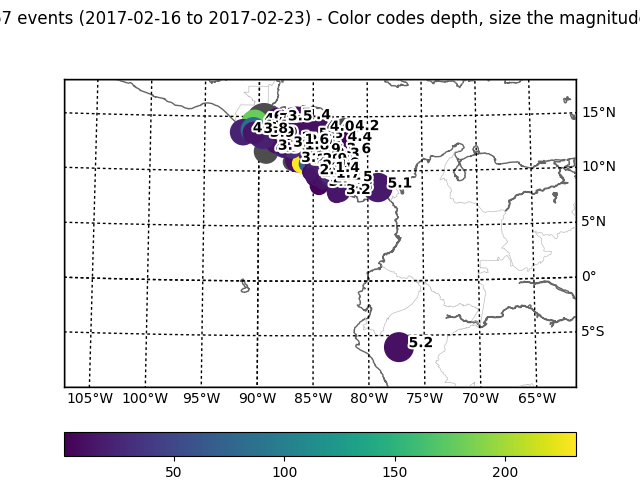

67 Event(s) in Catalog:
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
2017-02-18T18:13:31.480591Z | +13.057,  -85.389 | 5.30898918 M  | automatic
2017-02-20T07:45:13.676429Z |  -6.078,  -77.285 | 5.188626513 M  | manual
2017-02-20T19:35:48.206558Z |  +8.502,  -79.069 | 5.073081339 M  | manual
2017-02-17T02:53:28.699011Z | +12.517,  -86.366 | 4.918598008 M  | automatic
2017-02-16T13:33:43.548449Z | +14.391,  -90.407 | 4.697169061 M  | manual
2017-02-16T21:48:28.611592Z | +13.550,  -91.472 | 4.576897658 M  | manual
2017-02-17T18:20:49.774332Z | +11.819,  -85.549 | 4.54102991 M  | automatic
2017-02-22T22:10:52.931751Z | +11.083,  -86.416 | 4.519285499 M  | automatic
2017-02-16T21:02:57.007797Z | +12.320,  -86.068 | 4.45025206 M  | automatic
2017-02-18T23:31:33.639969Z | +13.772,  -90.515 | 4.435161694 M  | manual
2017-02-18T15:26:47.323932Z | +12.774,  -82.727 | 4.399470899 M  | automatic
2017-02-19T04:27:21.586677Z | +14.784,  -86.532 | 4.390860411 M  | automa

In [81]:
url="http://165.98.224.52:8081/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&orderby=magnitude"
cat = obspy.read_events(str(url))
fig = cat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None')#,colormap='autumn')
print(cat.__str__(print_all=True))

### The most important earthquakes

<IPython.core.display.Javascript object>


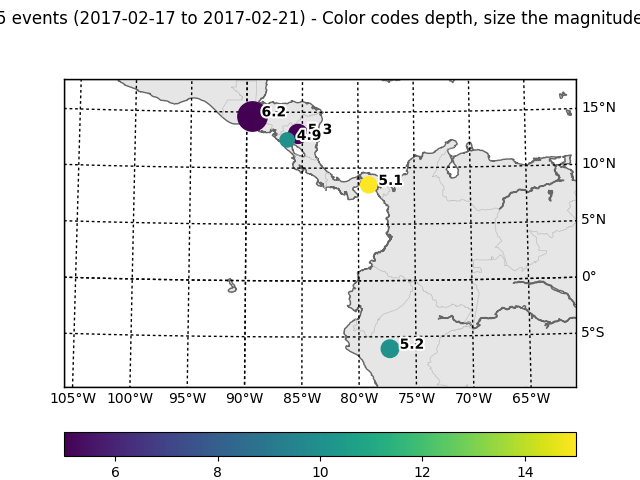

5 Event(s) in Catalog:
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
2017-02-18T18:13:31.480591Z | +13.057,  -85.389 | 5.30898918 M  | automatic
2017-02-20T07:45:13.676429Z |  -6.078,  -77.285 | 5.188626513 M  | manual
2017-02-20T19:35:48.206558Z |  +8.502,  -79.069 | 5.073081339 M  | manual
2017-02-17T02:53:28.699011Z | +12.517,  -86.366 | 4.918598008 M  | automatic


In [84]:
url="http://165.98.224.52:8081/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&minmag="minM"&orderby=magnitude"
subcat = obspy.read_events(str(url))
fig = subcat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None',colormap='autumn')
fig.bmap.bluemarble()
print(subcat.__str__(print_all=True))

## Observations by INETER EEW

<IPython.core.display.Javascript object>


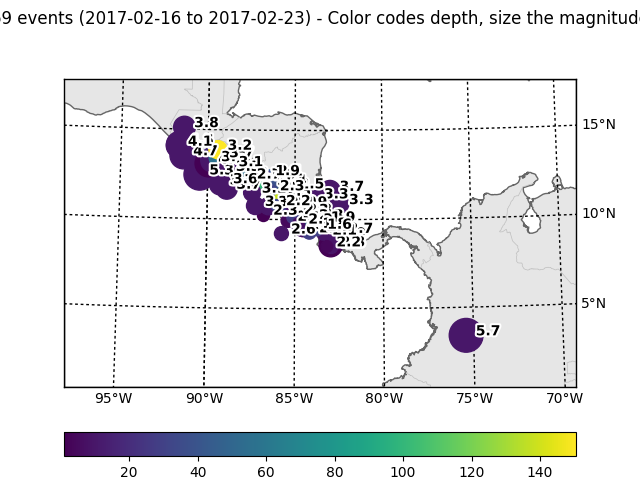

69 Event(s) in Catalog:
2017-02-21T14:12:30.428596Z |  +3.420,  -75.416 | 5.686401657 M  | automatic
2017-02-17T23:35:16.282402Z | +12.468,  -90.459 | 5.316994555 M  | automatic
2017-02-16T21:48:30.031656Z | +13.522,  -91.405 | 4.659562132 M  | automatic
2017-02-16T13:33:57.718739Z | +13.098,  -89.959 | 4.642505504 M  | automatic
2017-02-18T23:31:22.642209Z | +14.123,  -91.650 | 4.503060606 M  | automatic
2017-02-19T00:28:58.873987Z | +14.053,  -91.724 | 4.142563577 M  | automatic
2017-02-21T21:14:24.799314Z | +13.353,  -89.711 | 4.139209145 M  | automatic
2017-02-19T02:45:41.236109Z |  +8.567,  -82.967 | 4.033049702 M  | automatic
2017-02-17T07:21:36.482306Z | +13.215,  -89.557 | 3.840391847 M  | automatic
2017-02-23T08:42:37.248739Z | +15.106,  -91.386 | 3.807721706 M  | automatic
2017-02-21T19:43:58.358043Z | +13.229,  -89.516 | 3.80495215 M  | automatic
2017-02-18T16:08:30.024703Z | +11.933,  -89.282 | 3.702502806 M  | automatic
2017-02-19T14:21:08.869940Z | +13.226,  -89.798 | 3.6

In [108]:
url="http://localhost:18080/fdsnws/event/1/query?starttime="+start+"&endtime="+end+"&orderby=magnitude"
eewcat = obspy.read_events(str(url))
fig = eewcat.plot(projection='local',resolution='i')#,continent_fill_color='None',water_fill_color='None')#,colormap='autumn')
print(eewcat.__str__(print_all=True))

### Misfits 
Are they false alarms ?